# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

## 09 PyTorch Kaggle Image Data-set loading with CNN

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">

#### References:

- http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- https://www.bountysource.com/issues/44576966-a-tutorial-on-writing-custom-datasets-samplers-and-using-transforms

- https://medium.com/towards-data-science/my-first-kaggle-competition-9d56d4773607

- https://github.com/sohyongsheng/kaggle-planet-forest

- https://github.com/rwightman/pytorch-planet-amazon/blob/master/dataset.py




# PyTorch Imports


In [199]:
# !pip install pycuda
%reset -f
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2
import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)


tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.1.12+4eb448a
__CUDA VERSION
__CUDNN VERSION: 5110
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


# No GPU ... ? 

```
---------------------------------------------------------------------------
OSError                                   Traceback (most recent call last)
<ipython-input-3-64c0769366fe> in <module>()
     36 print('__Number CUDA Devices:', torch.cuda.device_count())
     37 print('__Devices')
---> 38 call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
     39 print('Active CUDA Device: GPU', torch.cuda.current_device())
     40 
```

In [200]:
# Torch CPU
# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 


## CUDA Trick

In [216]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

# Setting up global variables

- Root folder
- Image folder
- Image Label folder

In [217]:
DATA_ROOT ='/root/data/amazon/'
IMG_PATH = DATA_ROOT + '/train-jpg/'
IMG_EXT = '.jpg'
IMG_DATA_LABELS = DATA_ROOT + '/train_v2.csv'

# The Torch Dataset Class

In [218]:
try:
    from PIL import Image
except ImportError:
    import Image
    
class GenericImageDataset(Dataset):    

    def __init__(self, csv_path, img_path, img_ext, transform=None):
        
        t = time.time()        
        lgr.info('CSV path {}'.format(csv_path))
        lgr.info('IMG path {}'.format(img_path))        
        
        assert img_ext in ['.jpg']
        
        tmp_df = pd.read_csv(csv_path, header=None)
                        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df[0]        
#         self.X_train = self.X_train.ix[1:]
        
        self.y_train = self.mlb.fit_transform(tmp_df[1].str.split()).astype(np.float32)         
                
#         lgr.info("DF:\n" + str (self.X_train))
#         lgr.info ("self.y_train:\n" + str(self.y_train))

        lgr.info('[*]Dataset loading time {}'.format(time.time() - t))
        lgr.info('[*] Data size is {}'.format(len(self)))

    def __getitem__(self, index):
#         lgr.info ("__getitem__:" + str(index))
        path=self.img_path + self.X_train[index] + self.img_ext
#         lgr.info (" --- get item path:" + path)
        img = Image.open(path)
        img = img.convert('RGB')
        if self.transform is not None: # TypeError: batch must contain tensors, numbers, or lists; 
                                     #found <class 'PIL.Image.Image'>
            img = self.transform(img)
#             print (str (type(img))) # <class 'torch.FloatTensor'>                
        label = torch.from_numpy(self.y_train[index])
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
#         lgr.info ("Lenght:" +str(l))
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0

    @staticmethod
    def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

# The Torch transforms.ToTensor() methood

- Converts: a PIL.Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

In [219]:
# transformations = transforms.Compose([transforms.ToTensor()])
transformations = transforms.Compose([transforms.Scale(32),transforms.ToTensor()])

# The Torch DataLoader Class

- Will load our GenericImageDataset
- Can be regarded as a list (or iterator, technically). 
- Each time it is invoked will provide a minibatch of (img, label) pairs.

In [220]:
dset_train = GenericImageDataset(IMG_DATA_LABELS,
                                 IMG_PATH,
                                 IMG_EXT,transformations)

# train_loader = DataLoader(dset_train,
#                           batch_size=64,
#                           shuffle=False,
#                           num_workers=1 # 1 for CUDA
#                          # pin_memory=True # CUDA only
#                          )
# import torchvision

INFO:__main__:CSV path /root/data/amazon//train_v2.csv
INFO:__main__:IMG path /root/data/amazon//train-jpg/
INFO:__main__:[*]Dataset loading time 0.133418798447
INFO:__main__:[*] Data size is 40479


# Train Validation Split

- Since there is no train_test_split method in PyTorcj, we have to split a TRAINNING dataset into training and validation sets.

In [221]:
class FullTrainningDataset(torch.utils.data.Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        assert len(full_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(FullTrainningDataset, self).__init__()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.full_ds[i+self.offset]
    
validationRatio=0.22    

def trainTestSplit(dataset, val_share=validationRatio):
    val_offset = int(len(dataset)*(1-val_share))
    return FullTrainningDataset(dataset, 0, val_offset), FullTrainningDataset(dataset, val_offset, len(dataset)-val_offset)

 
train_ds, val_ds = trainTestSplit(dset_train)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=1)

# Test the DataLoader Class

INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


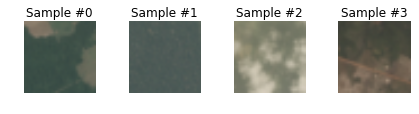

In [222]:
imagesToShow=4

for i, data in enumerate(train_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


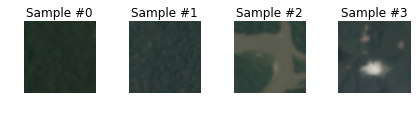

In [223]:
for i, data in enumerate(val_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

# The NN model

- We will use a simple CNN with conv(3x3) -> bn -> relu -> pool(4x4) -> fc.

- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

- `__init__: constructor. Create layers here. Note that we don't define the connections between layers in this function.`


- `forward(x): forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.` 

In [224]:
# https://www.kaggle.com/mratsim/starting-kit-for-pytorch-deep-learning/code/notebook
class Net(nn.Module):
    def __init__(self, initKernel='uniform'):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2304, 256)
        self.fc2 = nn.Linear(256, 17)
        
        # xavier initializer
        if initKernel == 'uniform':
            nn.init.xavier_uniform(self.conv1.weight, gain=np.sqrt(2.0))
        else:
            nn.init.kaiming_normal(self.conv1.weight)                    

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1) # Flatten layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)
    
    
if use_cuda:
    lgr.info ("Using the GPU")
    model = Net().cuda() # On GPU
else:
    lgr.info ("Using the CPU")
    model = Net() # On CPU

lgr.info('Model {}'.format(model))



INFO:__main__:Using the GPU
INFO:__main__:Model Net (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (2304 -> 256)
  (fc2): Linear (256 -> 17)
)


#  Loss and Optimizer

- Select a loss function and the optimization algorithm.

In [225]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(net.parameters(), lr=1e-1,momentum=0.9, weight_decay=1e-4)
lgr.info('Optimizer {}'.format(optimizer))

# criterion = nn.ClassNLLCriterion() -- a negative log-likelihood criterion for multi-class classification

INFO:__main__:Optimizer <torch.optim.sgd.SGD object at 0x7f2d030146d0>


# Start training in Batches

See example here:
http://codegists.com/snippet/python/pytorch_mnistpy_kernelmode_python

Epoch 1


INFO:__main__:Train Epoch: 1 [0/31573 (0%)]	Loss: 0.254982
INFO:__main__:Train Epoch: 1 [6400/31573 (20%)]	Loss: 0.254217
INFO:__main__:Train Epoch: 1 [12800/31573 (40%)]	Loss: 0.200380
INFO:__main__:Train Epoch: 1 [19200/31573 (61%)]	Loss: 0.260978
INFO:__main__:Train Epoch: 1 [25600/31573 (81%)]	Loss: 0.254939


Epoch 2


INFO:__main__:Train Epoch: 2 [0/31573 (0%)]	Loss: 0.258418
INFO:__main__:Train Epoch: 2 [6400/31573 (20%)]	Loss: 0.237088
INFO:__main__:Train Epoch: 2 [12800/31573 (40%)]	Loss: 0.190063
INFO:__main__:Train Epoch: 2 [19200/31573 (61%)]	Loss: 0.255481
INFO:__main__:Train Epoch: 2 [25600/31573 (81%)]	Loss: 0.251613


GPU: 74.952 seconds


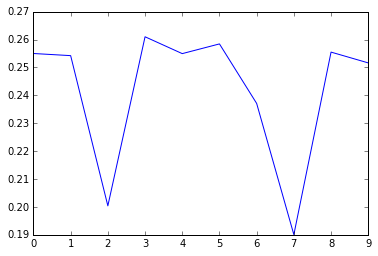

In [233]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
 
    
clf=model 
opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.5)
 
loss_history = []
acc_history = []
 
def train(epoch):
    clf.train() # set model in training mode (need this because of dropout)
     
    # dataset API gives us pythonic batching 
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            data, target = Variable(data.cuda(async=True)), Variable(target.cuda(async=True)) # On GPU                
        else:            
            data, target = Variable(data), Variable(target) # RuntimeError: expected CPU tensor (got CUDA tensor)                           
                 
        # forward pass, calculate loss and backprop!
        opt.zero_grad()
        preds = clf(data)
#         loss = F.nll_loss(preds, target)
        if use_cuda:
            loss = F.binary_cross_entropy(preds, target).cuda()
        else:
            loss = F.binary_cross_entropy(preds, target)
        loss.backward()
        
        opt.step()
        
        
        if batch_idx % 100 == 0:
            loss_history.append(loss.data[0])
            lgr.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))              

            
start_time = time.time()    

for epoch in range(1, 3):
    print("Epoch %d" % epoch)
    train(epoch)    
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

In [237]:
def test(epoch):
    clf.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0
     
    for data, target in val_loader:
        
        if use_cuda:
            data, target = Variable(data.cuda(async=True)), Variable(target.cuda(async=True)) # On GPU                
        else:            
            data, target = Variable(data), Variable(target) # RuntimeError: expected CPU tensor (got CUDA tensor)               
         
        output = clf(data)
        test_loss += F.binary_cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.long()).cpu().sum()
 
    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    acc_history.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

    
for epoch in range(1, 3):
    print("Epoch %d" % epoch)
    test(epoch)    

Epoch 1


RuntimeError: sizes do not match at /root/pytorch/torch/lib/THC/generated/../THCTensorMathCompareT.cuh:65

In [214]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=py09.html \
    './09 PyTorch Kaggle Image Data-set loading with CNN'

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
[NbConvertApp] Converting notebook ./09 PyTorch Kaggle Image Data-set loading with CNN.ipynb to slides
[NbConvertApp] Writing 397955 bytes to ./py09.html.slides.html
